In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 100
n_loci = 2000
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Text(0.5, 0, 'individual')

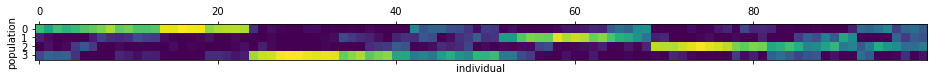

In [5]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [6]:
g_obs.shape

(100, 2000, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [8]:
print(prior_params_dict)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


In [9]:
dp_prior_alpha = prior_params_dict['dp_prior_alpha']
allele_prior_alpha = prior_params_dict['allele_prior_alpha']
allele_prior_beta = prior_params_dict['allele_prior_beta']

# Get VB params 

In [10]:
k_approx = 12

In [11]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [12]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2000, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (100, 11) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (100, 11) (lb=0.0001, ub=inf)


## Initialize 

In [13]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 412)

In [14]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

Text(0.5, 0, 'individual')

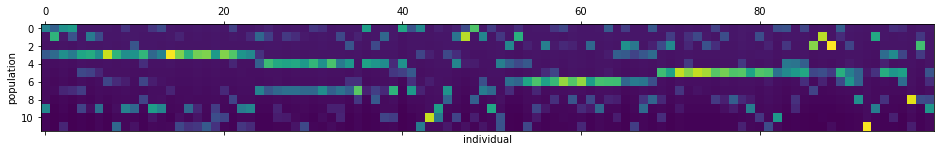

In [15]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Check KL's match

In [16]:
kl1 = structure_model_lib.get_kl(g_obs, vb_params_dict, 
                           prior_params_dict, gh_loc, gh_weights)

In [17]:
import vb_lib.structure_kl_old as ostructure_model_lib

In [18]:
kl2 = ostructure_model_lib.get_kl(g_obs, vb_params_dict, 
                           prior_params_dict, gh_loc, gh_weights)

In [19]:
kl1 - kl2

DeviceArray(1.17579475e-08, dtype=float64)

# Timing results

In [20]:
kl_flattened1 = paragami.FlattenFunctionInput(structure_model_lib.get_kl, 
                                              patterns = vb_params_paragami, 
                                              free = True, 
                                              argnums = 1)

objective_fun1 = jax.jit(lambda params : kl_flattened1(g_obs, params, prior_params_dict, gh_loc, gh_weights, 
                                                       log_phi = None, epsilon = None))

In [21]:
kl_flattened2 = paragami.FlattenFunctionInput(ostructure_model_lib.get_kl, 
                                              patterns = vb_params_paragami, 
                                              free = True, 
                                              argnums = 1)

objective_fun2 = jax.jit(lambda params : kl_flattened2(g_obs, params, prior_params_dict, gh_loc, gh_weights, 
                                                       log_phi = None, epsilon = None, 
                                                       e_z = None, set_optimal_z = True))

In [22]:
x = vb_params_paragami.flatten(vb_params_dict, free = True)

## Objective time

In [23]:
_ = objective_fun1(x)
_ = objective_fun2(x)

In [24]:
%timeit objective_fun1(x)

115 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%timeit objective_fun2(x)

281 ms ± 108 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Derivative times

In [26]:
get_grad1 = jax.jit(jax.grad(objective_fun1))
get_grad2 = jax.jit(jax.grad(objective_fun2))

In [27]:
grad1 = get_grad1(x)
grad2 = get_grad2(x)

In [28]:
np.abs(grad1 - grad2).max()

DeviceArray(7.95807864e-12, dtype=float64)

In [29]:
n_trials = 100

In [30]:
t0 = time.time()
for i in range(n_trials): 
    get_grad1(x)
    
print((time.time() - t0) / n_trials)

0.23420615196228028


In [31]:
t0 = time.time()
for i in range(n_trials): 
    get_grad2(x)
    
print((time.time() - t0) / n_trials)

0.5610585379600525


## Hessian vector products

In [32]:
def get_jac_hvp_fun(f):
    def hvp(x, v):
        return jax.jvp(jax.grad(f), (x, ), (v, ))[1]
    return hvp

In [33]:
get_hvp1 = jax.jit(get_jac_hvp_fun(objective_fun1))
get_hvp2 = jax.jit(get_jac_hvp_fun(objective_fun2))

In [34]:
hvp1 = get_hvp1(x, x)
hvp2 = get_hvp2(x, x)

In [35]:
np.abs(hvp1 - hvp2).max()

DeviceArray(5.00222086e-12, dtype=float64)

In [52]:
n_trials = 1

In [57]:
t0 = time.time()
for i in range(n_trials): 
    get_hvp1(x, x)
    
print((time.time() - t0) / n_trials)

0.0007779598236083984


In [58]:
t0 = time.time()
for i in range(n_trials): 
    get_hvp2(x, x)
    
print((time.time() - t0) / n_trials)

0.0006220340728759766
